### Deeper Stacked LSTM Model with Dropout and L2 Regularization

A deeper stacked LSTM model consists of multiple LSTM layers placed sequentially, allowing the network to learn complex temporal dependencies and hierarchical features by capturing short-term patterns in lower layers and longer-term ones in higher layers. To improve generalization and reduce overfitting, dropout is applied after each LSTM layer, randomly dropping neurons during training to prevent reliance on any single unit, which is important for deep models with many parameters. Additionally, L2 regularization adds a penalty on the squared magnitude of weights during training, encouraging smaller weights and controlling model complexity, making the combination of stacked LSTM, dropout, and L2 regularization a practical approach to building deep, robust, and expressive models for time-series forecasting tasks.

In [1]:
# --- Import additional layers and tools for experimentation ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Bidirectional, Dropout, Input, Layer
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

c:\Users\roji2\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\roji2\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\roji2\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [3]:
import os
print(os.getcwd())


d:\ProgonsAI\milestone_2\week_4\Day_17


In [5]:
import os

folder = r"D:\ProgonsAI\data\preprocessed"
print("Files in folder:", os.listdir(folder))


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\ProgonsAI\\data\\preprocessed'

In [6]:
import os
print(os.listdir("D:\\ProgonsAI"))


['.git', '.venv', 'data', 'LICENSE', 'LSTM_types.ipynb', 'milestone_1', 'milestone_2', 'one.txt', 'README.md']


In [7]:
import os
print(os.listdir("D:\\ProgonsAI\\data"))


['Damage Propagation Modeling.pdf', 'readme.txt', 'RUL_FD001.txt', 'RUL_FD002.txt', 'RUL_FD003.txt', 'RUL_FD004.txt', 'test_FD001.txt', 'test_FD002.txt', 'test_FD003.txt', 'test_FD004.txt', 'train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']


In [8]:
import glob

results_npy = glob.glob(r"D:\ProgonsAI\**\rolling_window_sequences.npy", recursive=True)
print("FOUND NPY:", results_npy)


FOUND NPY: ['D:\\ProgonsAI\\milestone_2\\week_3\\Day_14\\rolling_window_sequences.npy', 'D:\\ProgonsAI\\milestone_2\\week_4\\Day_15\\rolling_window_sequences.npy', 'D:\\ProgonsAI\\milestone_2\\week_4\\Day_16\\rolling_window_sequences.npy']


In [9]:
results_csv = glob.glob(r"D:\ProgonsAI\**\sequence_metadata_with_RUL.csv", recursive=True)
print("FOUND CSV:", results_csv)


FOUND CSV: ['D:\\ProgonsAI\\milestone_2\\week_3\\Day_11\\sequence_metadata_with_RUL.csv', 'D:\\ProgonsAI\\milestone_2\\week_3\\Day_14\\sequence_metadata_with_RUL.csv', 'D:\\ProgonsAI\\milestone_2\\week_4\\Day_15\\sequence_metadata_with_RUL.csv', 'D:\\ProgonsAI\\milestone_2\\week_4\\Day_16\\sequence_metadata_with_RUL.csv']


In [10]:
X = np.load(r"D:\ProgonsAI\milestone_2\week_4\Day_16\rolling_window_sequences.npy")
metadata = pd.read_csv(r"D:\ProgonsAI\milestone_2\week_4\Day_16\sequence_metadata_with_RUL.csv")

y = metadata["RUL"].values

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (152559, 30, 66)
y shape: (152559,)


In [11]:
# Split into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# Inspect sample batches
print("Sample X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])

Train shape: (122047, 30, 66) (122047,)
Val shape: (30512, 30, 66) (30512,)
Sample X_train[0] batch shape: (30, 66)
First 5 RUL targets: [ 56. 296.  86. 122. 121.]


In [ ]:
# Data Pipeline / Generator (optional, for very large data)
# Keras can accept Numpy arrays directly in fit(), so for most practical cases, we can skip writing a custom generator
# If memory is a concern, use tf.data.Dataset.from_tensor_slices
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
# val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

In [12]:
# Model with 2 stacked LSTM layers, dropout and L2 weight regularization
def build_stacked_lstm_model(input_shape, lstm_units=64, dropout_rate=0.3, l2_reg=1e-4):
    model = Sequential([
        LSTM(lstm_units, activation='tanh', return_sequences=True,
             kernel_regularizer=regularizers.l2(l2_reg),
             input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(lstm_units, activation='tanh', return_sequences=False,
             kernel_regularizer=regularizers.l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(1)
    ])
    return model

model_stacked = build_stacked_lstm_model(input_shape=(X.shape[1], X.shape[2]))
model_stacked.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_stacked.summary()


c:\Users\roji2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        33,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,625 (260.25 KB)

 Trainable params: 66,625 (260.25 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Traning Setup: Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1
)
model_ckpt = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1
)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)


Train: (122047, 30, 66) (122047,)
Val: (30512, 30, 66) (30512,)


In [16]:
import tensorflow as tf

BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [18]:
# Model Training
history = model_stacked.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, model_ckpt]
)

Epoch 1/30
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 15767.0091
Epoch 1: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 242s 127ms/step - loss: 13025.3750 - val_loss: 9364.5713 - learning_rate: 0.0010
Epoch 2/30
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 9044.8463
Epoch 2: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 339s 167ms/step - loss: 8116.4985 - val_loss: 5069.9429 - learning_rate: 0.0010
Epoch 3/30
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 4784.8078
Epoch 3: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 206s 108ms/step - loss: 4405.4561 - val_loss: 3632.2947 - learning_rate: 0.0010
Epoch 4/30
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 3748.7634
Epoch 4: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 201s 105ms/step - loss: 3614.6516 - val_loss: 3045.2454 - learning_rate: 0.0010
Epoch 5/30
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 3259.7024
Epoch 5: saving mo

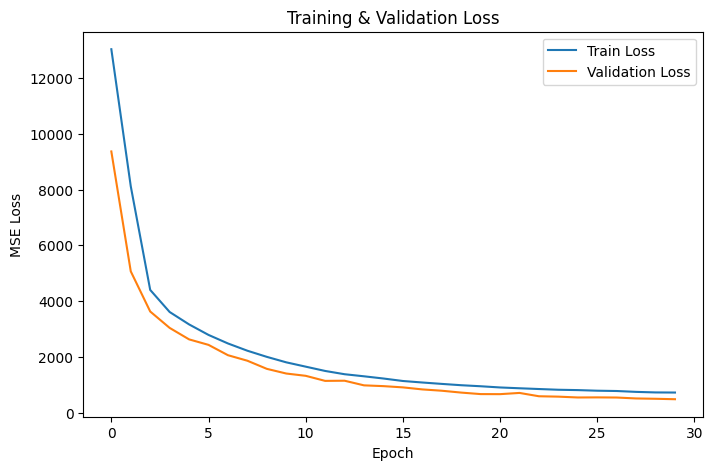

In [19]:
# Training and Validation Curves
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [21]:
from tensorflow.keras.models import load_model
import numpy as np

best_model = load_model("best_model.keras")

val_predictions = best_model.predict(X_val)
rmse = np.sqrt(np.mean((val_predictions - y_val.reshape(-1,1))**2))
mae = np.mean(np.abs(val_predictions - y_val.reshape(-1,1)))

print("Validation RMSE:", rmse)
print("Validation MAE:", mae)


954/954 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
Validation RMSE: 22.145414734218825
Validation MAE: 16.489267261070797


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


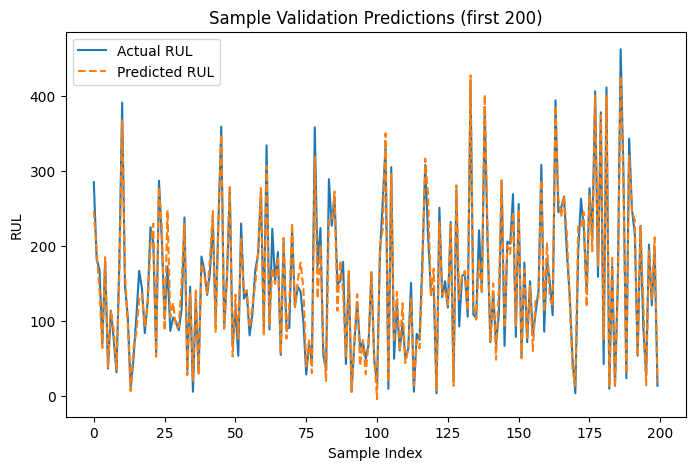

In [20]:
# Verify Model Predictions
val_pred = model_stacked.predict(X_val[:200]).flatten()
plt.figure(figsize=(8,5))
plt.plot(y_val[:200], label='Actual RUL')
plt.plot(val_pred, label='Predicted RUL', linestyle='--')
plt.title('Sample Validation Predictions (first 200)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()